In [100]:
import torchvision.models as models
import torch
from torchvision import transforms
from PIL import Image
from torch.nn.utils.rnn import *
from torch import nn
from torch.utils import data
import time
import pdb
from torch.autograd import Variable

import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
GPU = torch.cuda.is_available()
device = torch.device("cuda" if GPU else "cpu")
cuda = torch.cuda.is_available()
num_workers = 0 if cuda else 0
GPU

False

In [3]:
torch.cuda.empty_cache()

### Reading Data

In [18]:
numDataPointsWanted = 300
X = np.zeros((numDataPointsWanted, 3, 480, 640))
Y = np.zeros((numDataPointsWanted, 3))
dataType = "center"

transform = transforms.ToTensor()
root_path = "./"
with open(root_path + "labels.txt") as f:
    start = time.time()
    i = 0
    for line in f:
        [filename, radians, torque, speed] = line.split(' ')

        if filename[0:6] == "center":
            with Image.open(root_path + filename) as img:
                X[i,:,:,:] = (transform(img.convert('RGB')))
            Y[i,0] = (((float(radians) * 180.0)/np.pi))
            Y[i,1] = float(torque)
            Y[i,2] = float(speed)
            i += 1
            
        if i == numDataPointsWanted: break
    end = time.time()
    

print("Data loading complete, took", int(end - start), "seconds")
print('# Images loaded: ', len(X))

Data loading complete, took 4 seconds
# Images loaded:  300


In [21]:
trainX, valX, trainY, valY = train_test_split(X, Y, test_size=0.30)

# Feature Dataset

In [6]:
class Dataset(data.Dataset):
    def __init__(self, X, Y, seq_len):
        self.X = X
        self.Y = Y
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.X) // self.seq_len

    def __getitem__(self, index):
        idx = self.seq_len * index
        return self.X[idx:idx + self.seq_len], self.Y[idx + self.seq_len]

In [28]:
BATCH_SIZE = 2
num_workers = 0 if cuda else 0

train_set = Dataset(trainX, trainY, 15)
train_dataloader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_set = Dataset(valX, valY, 15)
val_dataloader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

# Our Model


In [112]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()

        assert hidden_channels % 2 == 0

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_features = 4

        self.padding = int((kernel_size - 1) / 2)

        self.Wxi = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whi = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxf = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whf = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxc = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whc = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxo = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Who = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)

        self.Wci = None
        self.Wcf = None
        self.Wco = None

    def forward(self, x, h, c):
        ci = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c * self.Wci)
        cf = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c * self.Wcf)
        cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))
        co = torch.sigmoid(self.Wxo(x) + self.Who(h) + cc * self.Wco)
        ch = co * torch.tanh(cc)
        return ch, cc

    def init_hidden(self, batch_size, hidden, shape):
        if self.Wci is None:
            self.Wci = Variable(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
            self.Wcf = Variable(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
            self.Wco = Variable(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
        else:
            assert shape[0] == self.Wci.size()[2], 'Input Height Mismatched!'
            assert shape[1] == self.Wci.size()[3], 'Input Width Mismatched!'
        return (Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).to(device),
                Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).to(device))


class ConvLSTM(nn.Module):
    # input_channels corresponds to the first input feature map
    # hidden state is a list of succeeding lstm layers.
    def __init__(self, input_channels, hidden_channels, kernel_size, step=1, effective_step=[1]):
        super(ConvLSTM, self).__init__()
        self.input_channels = [input_channels] + hidden_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = len(hidden_channels)
        self.step = step
        self.effective_step = effective_step
        self._all_layers = []
        for i in range(self.num_layers):
            name = 'cell{}'.format(i)
            cell = ConvLSTMCell(self.input_channels[i], self.hidden_channels[i], self.kernel_size)
            setattr(self, name, cell)
            self._all_layers.append(cell)

    def forward(self, input):
        internal_state = []
        outputs = []
        for step in range(self.step):
            x = input
            for i in range(self.num_layers):
                # all cells are initialized in the first step
                name = 'cell{}'.format(i)
                if step == 0:
                    bsize, _, height, width = x.size()
                    (h, c) = getattr(self, name).init_hidden(batch_size=bsize, hidden=self.hidden_channels[i],
                                                             shape=(height, width))
                    internal_state.append((h, c))

                # do forward
                (h, c) = internal_state[i]
                x, new_c = getattr(self, name)(x, h, c)
                internal_state[i] = (x, new_c)
            # only record effective steps
            outputs.append(x)

        return outputs, (x, new_c)

In [116]:
class Whip(nn.Module):
    def __init__(self, in_channels, out_channels, input_size, output_size):
        super(Whip, self).__init__()
        
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=(1, 4, 4), stride=2, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=(3, 12, 12), stride=2, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv3d(out_channels, out_channels, kernel_size=(1, 4, 4), stride=2)
        self.bn3 = nn.BatchNorm3d(out_channels)
        self.relu3 = nn.ReLU()
        
        self.avgpool = nn.AvgPool3d(1)
        
        self.convLSTM = ConvLSTM(input_channels=out_channels, hidden_channels= [512, 128, 64, 32], 
                                 kernel_size=3)
        
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        output = self.conv1(x) 
        output = self.bn1(output)
        output = self.relu1(output)
        
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        
        output = self.avgpool(output).squeeze(2)
        
        output, hidden = self.convLSTM(output)
        output = output[0]
#         pdb.set_trace()
        
        featuresV = output.reshape(output.size(0), -1)
        output = self.fc(featuresV)
        return output

In [117]:
context_size = 15
out_channels = 13
input_size = 140448

# we will be predicting angle, torque, and speed
output_size = 3
model = Whip(context_size, out_channels, input_size, output_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = nn.MSELoss()

print(model)

Whip(
  (conv1): Conv3d(15, 13, kernel_size=(1, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn1): BatchNorm3d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv3d(13, 13, kernel_size=(3, 12, 12), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn2): BatchNorm3d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv3d(13, 13, kernel_size=(1, 4, 4), stride=(2, 2, 2))
  (bn3): BatchNorm3d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (avgpool): AvgPool3d(kernel_size=1, stride=1, padding=0)
  (convLSTM): ConvLSTM(
    (cell0): ConvLSTMCell(
      (Wxi): Conv2d(13, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Whi): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (Wxf): Conv2d(13, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Whf): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padd

In [119]:
def combine(x, y):
    total = 0
    for v in range(len(x)):
        if x[v] and y[v]:
            total += 1
    return total

In [120]:
def train(num_epochs, model, save):
    EPOCH_TRAIN_LOSSES = []
    EPOCH_VAL_LOSSES = []
    EPOCH_TRAIN_ACC = []
    EPOCH_VAL_ACC = []
    train_a_acc = []
    val_a_acc = []
    
    for epoch in range(num_epochs):
        start = time.time()

        running_train_loss = 0.0
        running_val_loss = 0.0
        train_correct = 0.0
        val_correct = 0.0
        train_total = 0.0
        val_total = 0.0
               
        t_correct_predictions_0_5 = 0.0
        t_correct_predictions_1 = 0.0
        t_correct_predictions_2 = 0.0
        t_correct_predictions_5 = 0.0
        t_correct_predictions_g_5 = 0.0
        
        v_correct_predictions_0_5 = 0.0
        v_correct_predictions_1 = 0.0
        v_correct_predictions_2 = 0.0
        v_correct_predictions_5 = 0.0
        v_correct_predictions_g_5 = 0.0

        model.train()
        for i, (x, label) in enumerate(train_dataloader):
            x, label = x.to(device), label.to(device)
            optimizer.zero_grad()
            y = model(x.float()).double().squeeze(1)
            
            loss = criterion(y, label)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            predicted_angles = y[0]
            label_angles = label[0]
            train_correct += torch.sum(torch.abs(predicted_angles - label_angles) < 0.1).item()
            t_correct_predictions_0_5 += torch.sum(torch.abs(predicted_angles - label_angles) <= 0.5).item()
            t_correct_predictions_1 += combine(torch.abs(predicted_angles - label_angles) > 0.5,  torch.abs(predicted_angles - label_angles) <= 1)
            t_correct_predictions_2 += combine(torch.abs(predicted_angles - label_angles) > 1,  torch.abs(predicted_angles - label_angles) <= 2)
            t_correct_predictions_5 += combine(torch.abs(predicted_angles - label_angles) > 2,  torch.abs(predicted_angles - label_angles) <= 5)
            v_correct_predictions_g_5 += torch.sum(torch.abs(predicted_angles - label_angles) > 5).item()
            train_total += label_angles.size(0)
            
            del x
            del label
                    
        train_a_a = [t_correct_predictions_0_5, t_correct_predictions_1, t_correct_predictions_2, t_correct_predictions_5, t_correct_predictions_g_5]
        train_a_acc.append(train_a_a)

        model.eval()
        with torch.no_grad():
            for i, (x, label) in enumerate(val_dataloader):
                x, label = x.to(device), label.to(device)
                y = model(x.float()).double().squeeze(1)
                
                loss = criterion(y, label)

                running_val_loss += loss.item()
                predicted_angles = y[0]
                label_angles = label[0]
                val_correct += torch.sum(torch.abs(predicted_angles - label_angles) < 0.1).item()
                v_correct_predictions_0_5 += torch.sum(torch.abs(predicted_angles - label_angles) <= 0.5).item()
                v_correct_predictions_1 += combine(torch.abs(predicted_angles - label_angles) > 0.5,  torch.abs(predicted_angles - label_angles) <= 1)
                v_correct_predictions_2 += combine(torch.abs(predicted_angles - label_angles) > 1,  torch.abs(predicted_angles - label_angles) <= 2)
                v_correct_predictions_5 += combine(torch.abs(predicted_angles - label_angles) > 2,  torch.abs(predicted_angles - label_angles) <= 5)
                v_correct_predictions_g_5 += torch.sum(torch.abs(predicted_angles - label_angles) > 5).item()
                val_total += label_angles.size(0)
                
            val_a_a = [v_correct_predictions_0_5, v_correct_predictions_1, v_correct_predictions_2, v_correct_predictions_5, v_correct_predictions_g_5]
            val_a_acc.append(val_a_a)
                
        train_acc = (train_correct / (train_total))*100
        val_acc = (val_correct / (val_total))*100
        tloss = running_train_loss / len(train_dataloader)
        vloss = running_val_loss/ len(val_dataloader)

        print("EPOCH", epoch, "\t\tTook", int(time.time() - start), "s")
        print("Train Acc:", train_acc, "\tVal Acc:", val_acc)
        print("Avg Train Loss:", tloss, "\tAvg Val Loss:", vloss)

        scheduler.step(vloss)

        EPOCH_TRAIN_LOSSES.append(tloss)
        EPOCH_VAL_LOSSES.append(vloss)
        EPOCH_TRAIN_ACC.append(train_acc)
        EPOCH_VAL_ACC.append(val_acc)

        if save:
            torch.save(model.state_dict(), './model_' + str(epoch + 1) + '_' + str(val_acc) + '.pt')
            
    return EPOCH_TRAIN_LOSSES, EPOCH_VAL_LOSSES, EPOCH_TRAIN_ACC, EPOCH_VAL_ACC, val_a_acc, train_a_acc

In [121]:
n_epochs = 9
EPOCH_TRAIN_LOSSES, EPOCH_VAL_LOSSES, EPOCH_TRAIN_ACC, EPOCH_VAL_ACC, val_a_acc, train_a_acc = train(n_epochs, model, save=False)

EPOCH 0 		Took 122 s
Train Acc: 4.761904761904762 	Val Acc: 11.11111111111111
Avg Train Loss: 174.20337689505365 	Avg Val Loss: 167.55978498399574
EPOCH 1 		Took 118 s
Train Acc: 4.761904761904762 	Val Acc: 0.0
Avg Train Loss: 155.978467023095 	Avg Val Loss: 144.29903229888808
EPOCH 2 		Took 123 s
Train Acc: 4.761904761904762 	Val Acc: 0.0
Avg Train Loss: 86.14062673326076 	Avg Val Loss: 39.26066578944873
EPOCH 3 		Took 116 s
Train Acc: 4.761904761904762 	Val Acc: 0.0
Avg Train Loss: 18.892065911658666 	Avg Val Loss: 3.019997553794216
EPOCH 4 		Took 114 s
Train Acc: 9.523809523809524 	Val Acc: 0.0
Avg Train Loss: 8.354270422136457 	Avg Val Loss: 18.144323651881837
EPOCH 5 		Took 116 s
Train Acc: 9.523809523809524 	Val Acc: 22.22222222222222
Avg Train Loss: 6.694212398429367 	Avg Val Loss: 1.2611069230888938
EPOCH 6 		Took 117 s
Train Acc: 9.523809523809524 	Val Acc: 0.0
Avg Train Loss: 3.316786193707626 	Avg Val Loss: 2.3719494134548778
EPOCH 7 		Took 117 s
Train Acc: 9.523809523809524

# Plotting Results

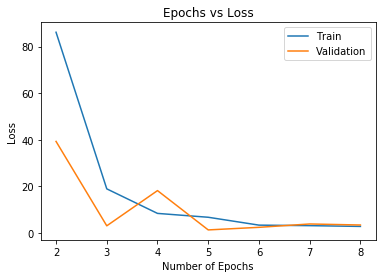

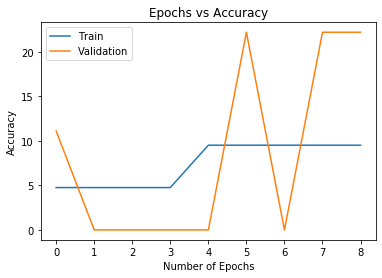

In [123]:
import matplotlib.pyplot as plt

ep = np.arange(n_epochs)

rangeVi = 2
rangeVf = 9
plt.plot(ep[rangeVi:rangeVf], EPOCH_TRAIN_LOSSES[rangeVi:rangeVf], label="Train")
plt.plot(ep[rangeVi:rangeVf], EPOCH_VAL_LOSSES[rangeVi:rangeVf], label="Validation")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()
plt.savefig('RNNLossFinal_ResNet_34.png')
plt.show()

plt.plot(ep, EPOCH_TRAIN_ACC, label="Train")
plt.plot(ep, EPOCH_VAL_ACC, label="Validation")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy")
plt.legend()
plt.savefig('RNNAccuracyFinal.png')
plt.show()